In [2]:
import numpy as np
import h5py
import torch
from haar_noising_script import apply_haar_scrambling

filename = "../../../data/QG1_normalized_16x16_100k"
data_X = np.array(h5py.File(filename, "r")['X'])

num_samples = 1000

encoded_data_load = torch.load("../../../data/Q1_16x16_1k_encoded.pt")
print(encoded_data_load.shape)

scrambled_states = apply_haar_scrambling(np.array(encoded_data_load), num_samples, seed=42)
scrambled_states = torch.tensor(scrambled_states, dtype=torch.float32)
print(scrambled_states.shape)

C:\Users\realc\AppData\Local\Temp\ipykernel_35652\4207966746.py:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  encoded_data_load = torch.load("../../../data/Q1_16x16_1k_e

torch.Size([1000, 8, 8, 4])
torch.Size([1000, 8, 8, 4])


C:\Users\realc\AppData\Local\Temp\ipykernel_35652\4207966746.py:35: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\Copy.cpp:305.)
  scrambled_states = torch.tensor(scrambled_states, dtype=torch.float32)


Epoch [1/50], Loss: 1.0218, Val Loss: 0.7261, FID: 184.4643
Epoch [2/50], Loss: 0.7298, Val Loss: 0.4736, FID: 119.5269
Epoch [3/50], Loss: 0.4765, Val Loss: 0.2615, FID: 64.8843
Epoch [4/50], Loss: 0.2672, Val Loss: 0.1094, FID: 25.6139
Epoch [5/50], Loss: 0.1180, Val Loss: 0.0358, FID: 6.3848
Epoch [6/50], Loss: 0.0447, Val Loss: 0.0471, FID: 8.8863
Epoch [7/50], Loss: 0.0583, Val Loss: 0.0985, FID: 21.8031
Epoch [8/50], Loss: 0.1134, Val Loss: 0.1264, FID: 28.8520
Epoch [9/50], Loss: 0.1390, Val Loss: 0.1189, FID: 26.9443
Epoch [10/50], Loss: 0.1328, Val Loss: 0.0908, FID: 19.8246
Epoch [11/50], Loss: 0.1037, Val Loss: 0.0609, FID: 12.2760
Epoch [12/50], Loss: 0.0739, Val Loss: 0.0393, FID: 6.8768
Epoch [13/50], Loss: 0.0523, Val Loss: 0.0274, FID: 3.9325
Epoch [14/50], Loss: 0.0372, Val Loss: 0.0227, FID: 2.8442
Epoch [15/50], Loss: 0.0328, Val Loss: 0.0231, FID: 3.0140
Epoch [16/50], Loss: 0.0325, Val Loss: 0.0257, FID: 3.7656
Epoch [17/50], Loss: 0.0341, Val Loss: 0.0280, FID: 4.

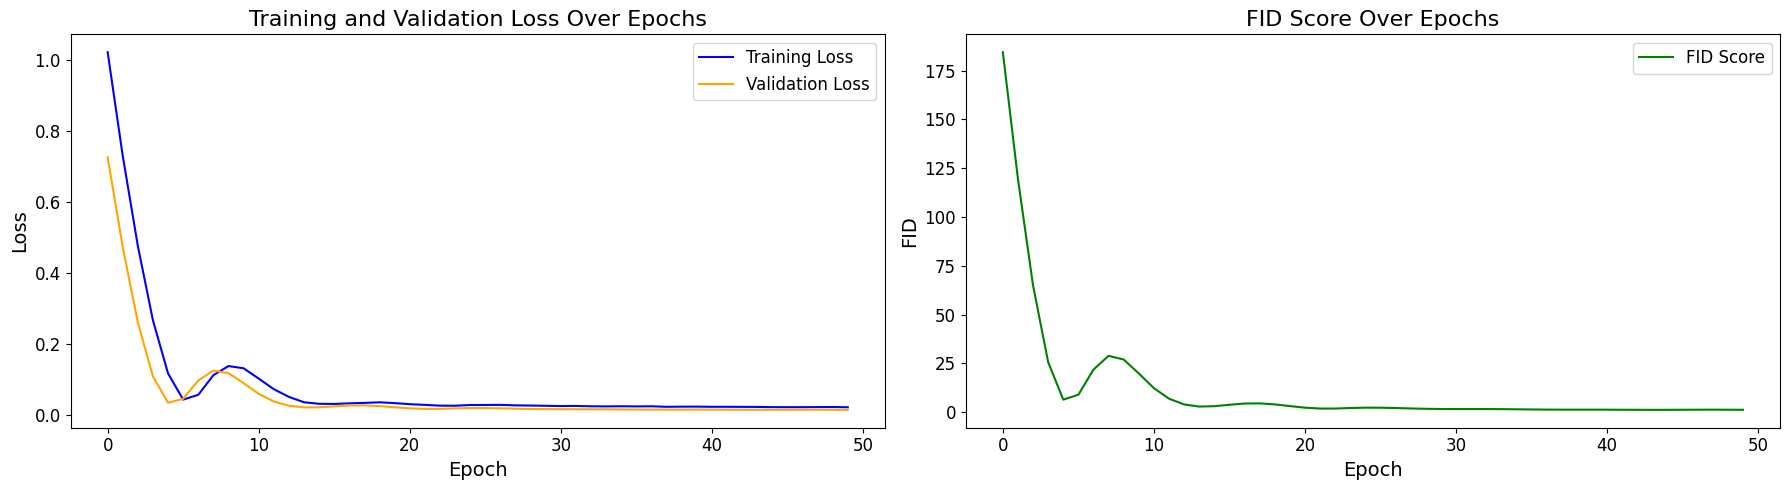

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import scipy.linalg
import pennylane as qml

encoded_data = encoded_data_load

train_encoded_data, val_encoded_data, train_scrambled_states, val_scrambled_states = train_test_split(
    encoded_data, scrambled_states, test_size=0.2, random_state=42, shuffle=True
)

n_qubits = 4
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev, interface='torch')
def quantum_circuit(inputs, weights):
    qml.templates.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.templates.StronglyEntanglingLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

class QuantumLayer(nn.Module):
    def __init__(self, n_qubits, n_layers):
        super(QuantumLayer, self).__init__()
        weight_shapes = {"weights": (n_layers, n_qubits, 3)}
        self.qlayer = qml.qnn.TorchLayer(quantum_circuit, weight_shapes)

    def forward(self, x):
        return self.qlayer(x)

class QuantumDiffusionModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_qubits, n_layers):
        super(QuantumDiffusionModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, n_qubits)
        self.quantum_layer = QuantumLayer(n_qubits, n_layers)
        self.fc2 = nn.Linear(n_qubits, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.quantum_layer(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

def decode(encoded_data):
    num_samples, encoded_height, encoded_width, num_channels = encoded_data.shape
    decoded_data = np.zeros((num_samples, 16, 16))

    for sample in range(num_samples):
        for i in range(encoded_height):
            for j in range(encoded_width):
                for c in range(num_channels):
                    if c == 0:
                        decoded_data[sample, 2*i, 2*j] = encoded_data[sample, i, j, c]
                    elif c == 1:
                        decoded_data[sample, 2*i, 2*j+1] = encoded_data[sample, i, j, c]
                    elif c == 2:
                        decoded_data[sample, 2*i+1, 2*j] = encoded_data[sample, i, j, c]
                    elif c == 3:
                        decoded_data[sample, 2*i+1, 2*j+1] = encoded_data[sample, i, j, c]

    return decoded_data

def flip(decoded_data):
    return 1 - decoded_data

def calculate_statistics(data):
    data = data.reshape(data.shape[0], -1)
    mean = np.mean(data, axis=0)
    covariance = np.cov(data, rowvar=False)
    return mean, covariance

def calculate_fid(mu1, sigma1, mu2, sigma2, eps=1e-6):
    diff = mu1 - mu2
    covmean, _ = scipy.linalg.sqrtm(sigma1 @ sigma2, disp=False)
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    fid = diff @ diff + np.trace(sigma1) + np.trace(sigma2) - 2 * np.trace(covmean)
    return fid

n_layers = 6
input_dim = 8 * 8 * 4 
hidden_dim = 128
output_dim = input_dim  

model = QuantumDiffusionModel(input_dim, hidden_dim, output_dim, n_qubits, n_layers)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

num_epochs = 50
loss_values = []
val_loss_values = []
fid_scores = []

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(train_scrambled_states.view(len(train_scrambled_states), -1))
    loss = criterion(outputs, train_encoded_data.view(len(train_encoded_data), -1))
    loss.backward()
    optimizer.step()
    loss_values.append(loss.item())
    
    model.eval()
    with torch.no_grad():
        val_outputs = model(val_scrambled_states.view(len(val_scrambled_states), -1))
        val_loss = criterion(val_outputs, val_encoded_data.view(len(val_encoded_data), -1))
        val_loss_values.append(val_loss.item())
        
        denoised_states = model(val_scrambled_states.view(len(val_scrambled_states), -1))
        denoised_states = denoised_states.view(len(val_scrambled_states), 8, 8, 4).detach().numpy()
        decoded_data = decode(denoised_states)
        decoded_data = flip(decoded_data)

        mu1, sigma1 = calculate_statistics(data_X[:len(decoded_data)])
        mu2, sigma2 = calculate_statistics(decoded_data)
        fid = calculate_fid(mu1, sigma1, mu2, sigma2)
        fid_scores.append(fid)
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}, FID: {fid:.4f}')

plt.figure(figsize=(18, 5))

plt.subplot(1, 2, 1)
plt.plot(loss_values, label='Training Loss', color='blue')
plt.plot(val_loss_values, label='Validation Loss', color='orange')
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.title('Training and Validation Loss Over Epochs', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)

plt.subplot(1, 2, 2)
plt.plot(fid_scores, label='FID Score', color='green')
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('FID', fontsize=14)
plt.title('FID Score Over Epochs', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)

plt.tight_layout()
plt.show()

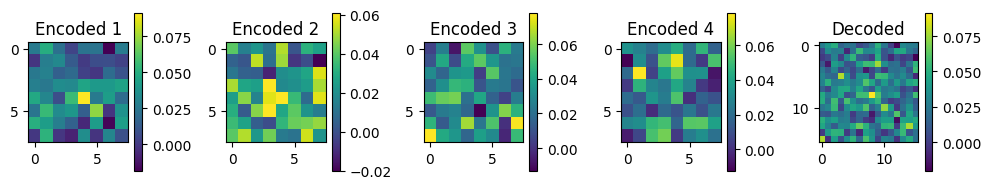

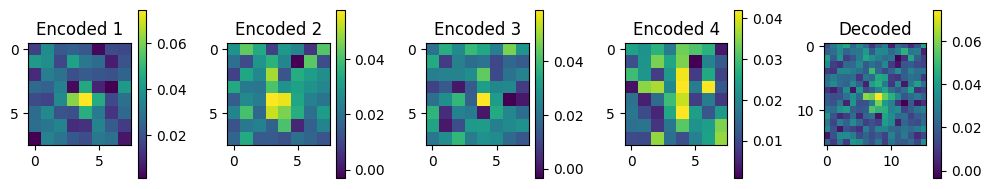

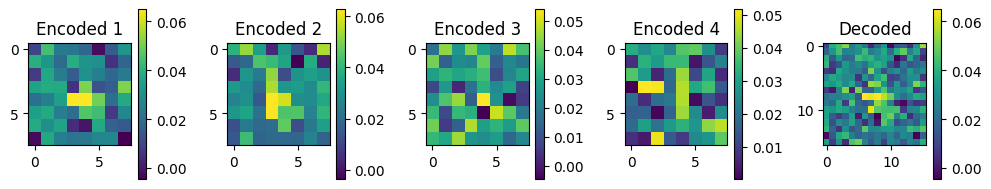

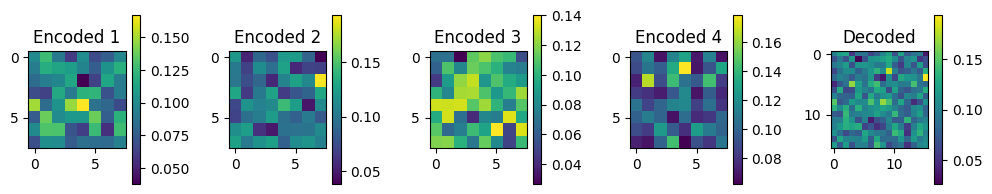

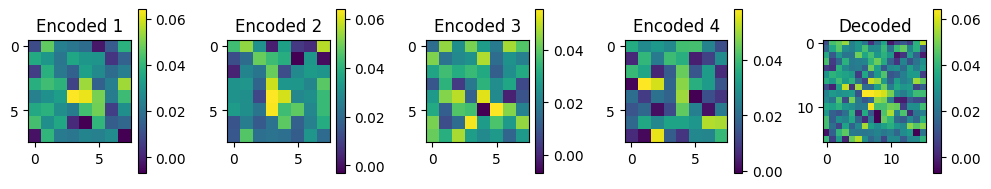

In [9]:
def generate_new_images(model, num_images, input_dim=8*8*4):
    model.eval()  
    with torch.no_grad():
        
        for i in range(num_images):
            random_noise = torch.randn(num_images, input_dim)
            
            generated_data = model(random_noise)
            generated_data = flip(generated_data.view(num_images, 8, 8, 4).detach().numpy())
            
            decoded_images = decode(generated_data)
            fig, axes = plt.subplots(1, 5, figsize=(10, 2))

            for qubit in range(4):
                im = axes[qubit].imshow(generated_data[i, :, :, qubit], cmap='viridis')
                axes[qubit].set_title(f"Encoded {qubit+1}")
                fig.colorbar(im, ax=axes[qubit])

            im = axes[4].imshow(decoded_images[i], cmap='viridis')
            axes[4].set_title("Decoded")
            fig.colorbar(im, ax=axes[4])
            
            plt.tight_layout()
            plt.show()

    return decoded_images

num_samples_to_generate = 5
new_images = generate_new_images(model, num_samples_to_generate)
